In [162]:
# base 
import os 
import sys
sys.path.append('..')
import src
import random 
import json 
import numpy as np
import pandas as pd 
import pandas.api.types as types
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pickle as pkl
from urllib.request import urlretrieve 
from typing import List, Set, Dict, Tuple
from typing import Union, Any, Optional

# ml preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier


# validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, plot_confusion_matrix

# pipelines 
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

In [92]:
# test
src.config.TRAIN_FILE_PATH

'/home/sanc/data/final'

In [161]:
pandas.api.types.is_bool(1)

False

In [93]:
%matplotlib inline 
sns.set_style('white')
sns.set_palette('deep')

In [94]:
# the iris dataset is used as a toy df 
from sklearn.datasets import fetch_openml

iris = fetch_openml(name="iris", version=1, as_frame=True)

df = iris['data']

In [95]:
type(df)

pandas.core.frame.DataFrame

### Statistics 

### Data preprocessing steps
- Creating - any features to engineer? 
- Correcting - any anomalies to correct? 
- Converting - any dtypes to correct? 
- Completing - any missing values to complete? 

In [164]:
types.is_numeric_dtype(df['sepalwidth'])

True

MISSINGNESS THROUGHOUT THE DATA


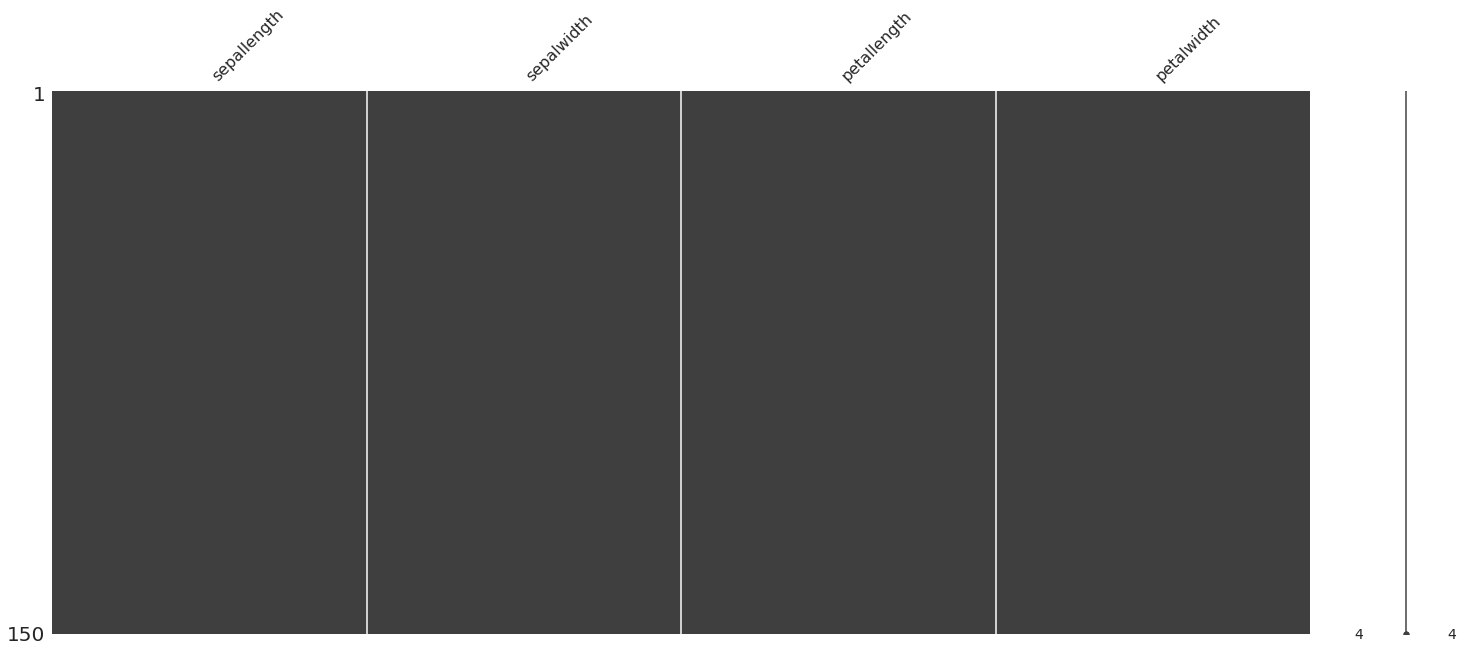

MISSINGNESS CORRELATIONS


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


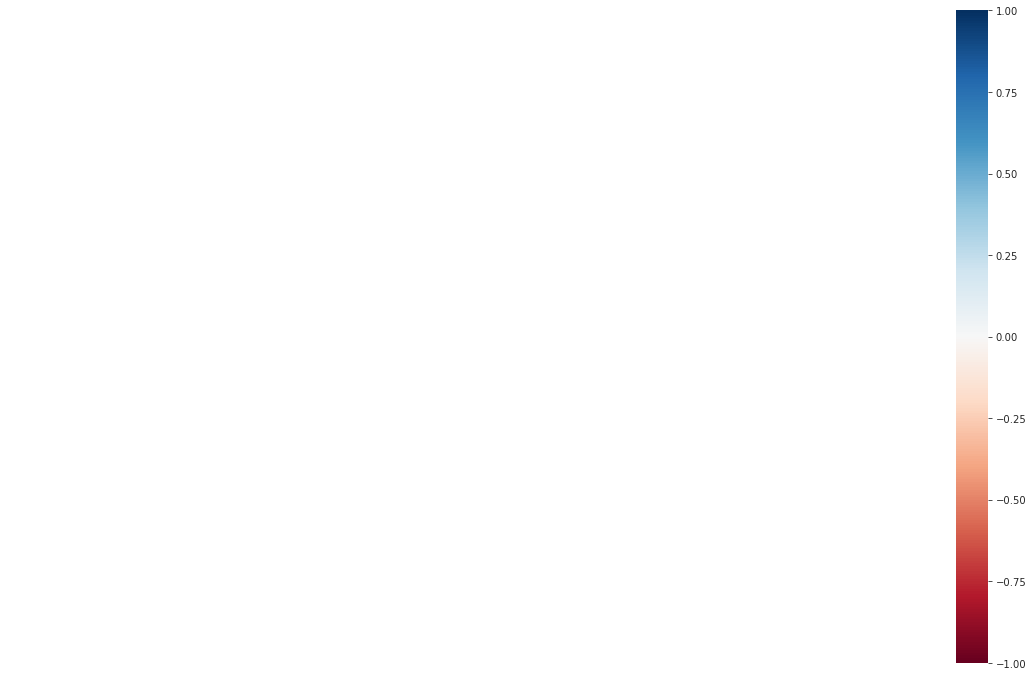

In [114]:
view_missing(df)

In [98]:
# try to use type hinting where possible so as to prevent unintended behaviour
# Example function 
def double(n: str) -> str: 
    '''
    docstrings here
    '''
    return n*2 

In [219]:
## helper functions 

#def df_drop_duplicates(df )


def missingness_checks(df: pd.DataFrame) -> None:
    
    print(f'NUMBER OF MISSING COLUMNS: {df.isna().sum().sum()}')
    print(f'MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES')
    print(df.isna().sum())
    print('\n')
    print('MISSINGNESS THROUGHOUT THE DATA')
    msno.matrix(df) 
    plt.show()
    print('MISSINGNESS CORRELATIONS')
    msno.heatmap(df)
    plt.show() 

NUMBER OF MISSING COLUMNS: 0
MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES
sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
dtype: int64


MISSINGNESS THROUGHOUT THE DATA


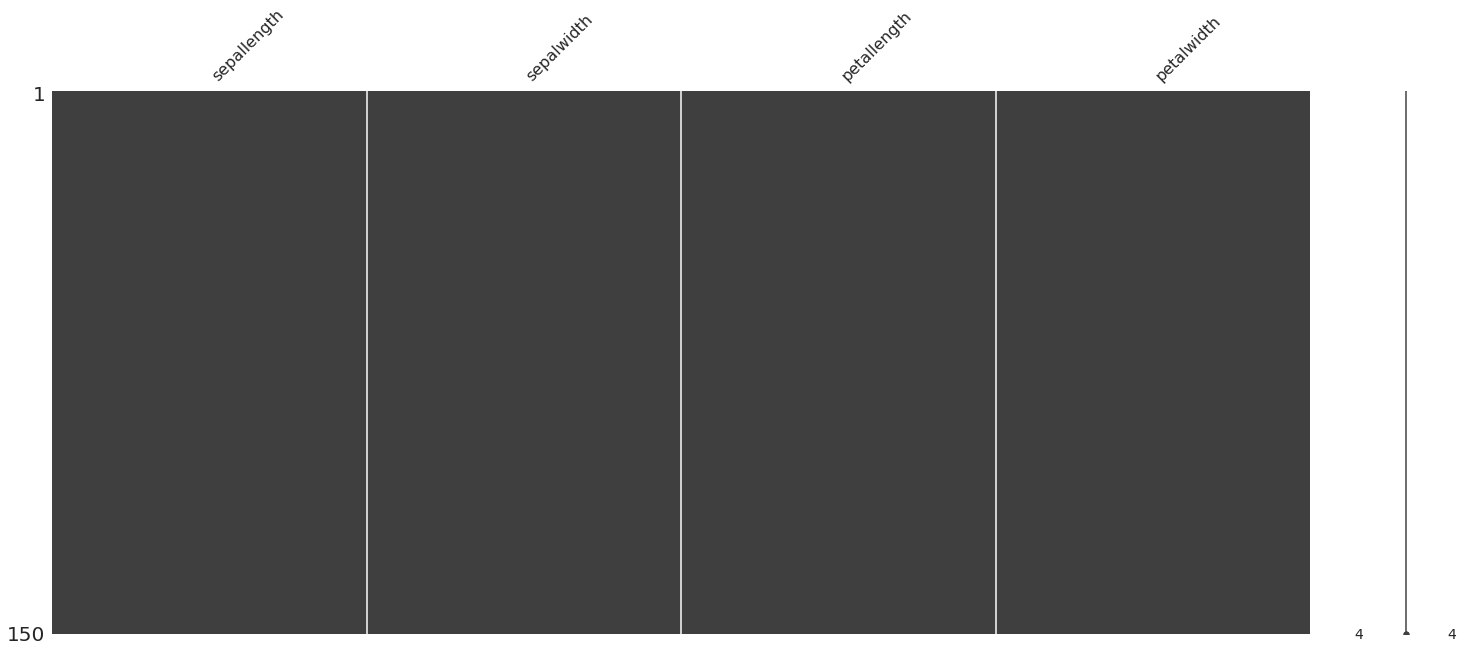

MISSINGNESS CORRELATIONS


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


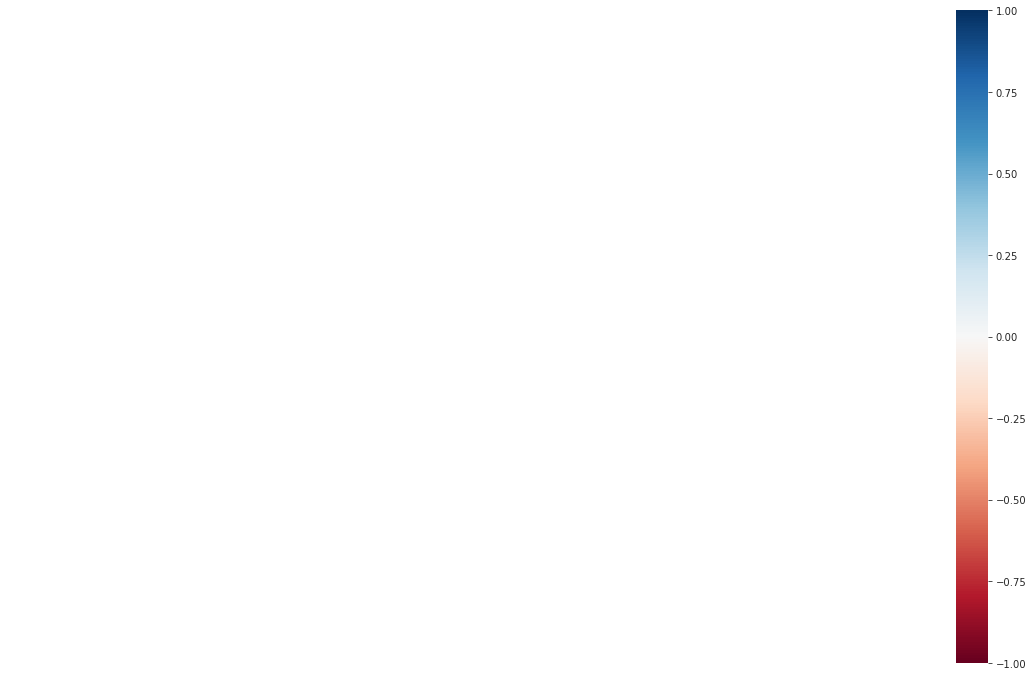

In [220]:
missingness_checks(df)

In [169]:
def get_dtypes(df: pd.DataFrame) -> Dict:
    return df.dtypes.to_dict()

In [ ]:
def quick_plot(df: pd.DataFrame) -> None: 
    pass 

In [167]:
dtypes = get_dtypes(df)
dtypes

{'sepallength': dtype('float64'),
 'sepalwidth': dtype('float64'),
 'petallength': dtype('float64'),
 'petalwidth': dtype('float64')}

In [201]:
def get_numeric_columns(df: pd.DataFrame) -> List: 
    return [col for col in df.columns if types.is_numeric_dtype(df[col])]


def get_categorical_columns(df: pd.DataFrame) -> List: 
    return [col for col in df.columns if types.is_categorical_dtype(df[col])]


def convert_to_dtype(col: pd.Series, type: str) -> pd.Series:
    if type not in ['numeric', 'categorical']: 
        raise ValueError('Please enter a valid dtype of either: "numeric" or "categorical"') 
    elif type == 'numeric': 
        return pd.to_numeric(col, errors='raise')
    return col.astype('category')


In [227]:
def replace_missing_values(col: pd.Series, strategy: str, constant: str) -> pd.Series: 
    if strategy not in ['c', 'mean', 'median']

In [229]:
df.isnull().sum()

sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
dtype: int64

In [226]:
help(return_value_counts)

Help on function return_value_counts in module __main__:

return_value_counts(df: pandas.core.frame.DataFrame) -> None
    ahtgildash fsidfh asiulfs



In [225]:
def return_value_counts(df: pd.DataFrame) -> None: 
    '''
    ahtgildash fsidfh asiulfs

    '''
    for col in df.columns: 
        print(col.upper())
        print('####################################')
        print(df[col].value_counts())
        print('\n')


In [178]:
df.sepallength = df.sepallength.astype(pd.CategoricalDtype())

/tmp/ipykernel_23463/3633521797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sepallength = df.sepallength.astype(pd.CategoricalDtype())


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sepallength  150 non-null    category
 1   sepalwidth   150 non-null    float64 
 2   petallength  150 non-null    float64 
 3   petalwidth   150 non-null    float64 
dtypes: category(1), float64(3)
memory usage: 5.1 KB


In [173]:
num_cols = get_numeric_columns(df)
num_cols

['sepallength', 'sepalwidth', 'petallength', 'petalwidth']

In [130]:
def set_up_fig(rows: int=1) -> None: 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
    for s in ['top', 'right']: 
        ax.spines[s].set_visible(False)



def quick_eda(df: pd.DataFrame) -> None: 
    print(f'DATAFRAME HAS {df.shape[0]} ROWS AND {df.shape[1]} COLS')
    print(df.info())
    display(df.describe().T)
    display(df.head(5))

MISSINGNESS THROUGHOUT THE DATA


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/missingno/missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


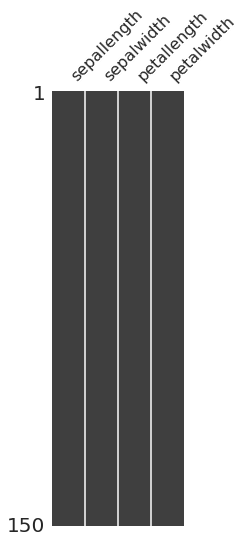

In [136]:
missingness_checks(df)

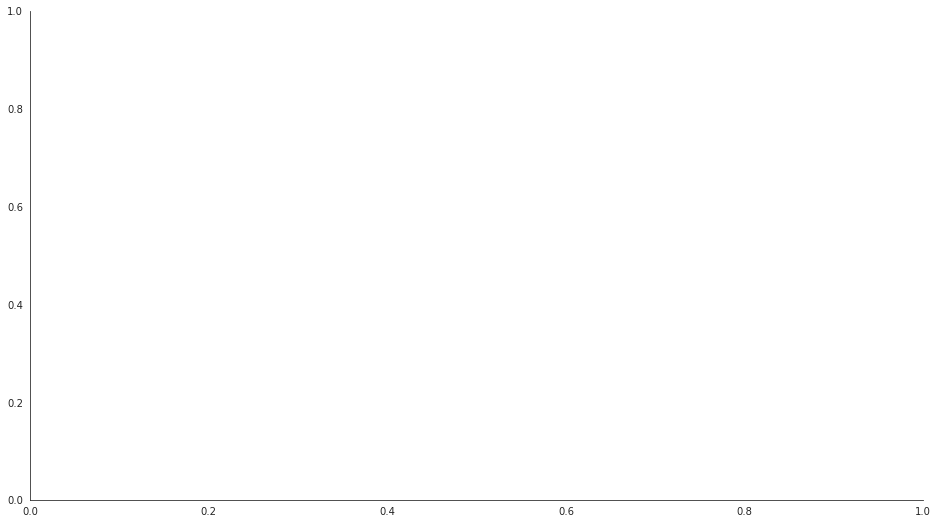

In [ ]:
## standardize columns 

def standardize_cols(col: str) -> str: 
    return col.lower().strip().replace(' ', '-') 

def visualize_cols(col: str) -> str: 
    return col.capitalize().replace('-', ' ')


NUMBER OF MISSING COLUMNS: 0
MISSING COLUMNS (0: NO MISSING VALUES, 1: MISSING VALUES
sepallength    0
sepalwidth     0
petallength    0
petalwidth     0
dtype: int64
MISSINGNESS THROUGHOUT THE DATA


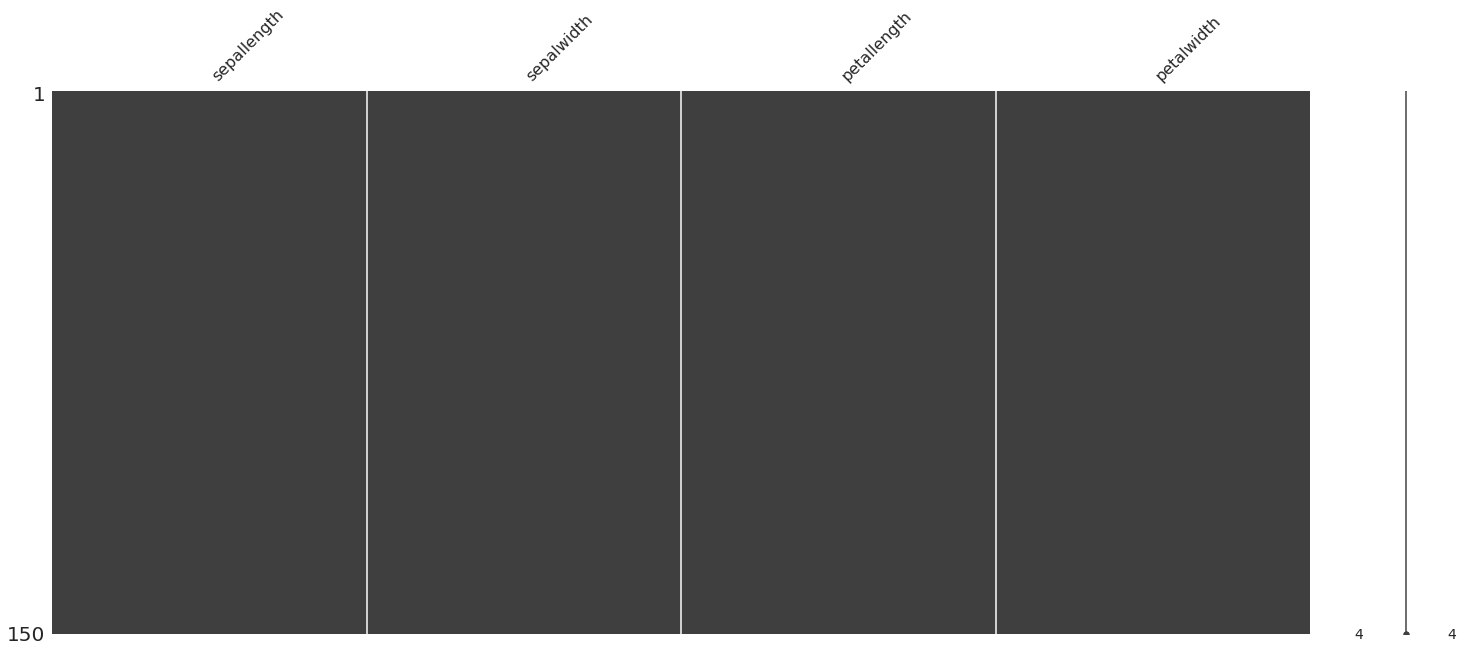

MISSINGNESS CORRELATIONS


/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/sanc/anaconda3/envs/aml/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


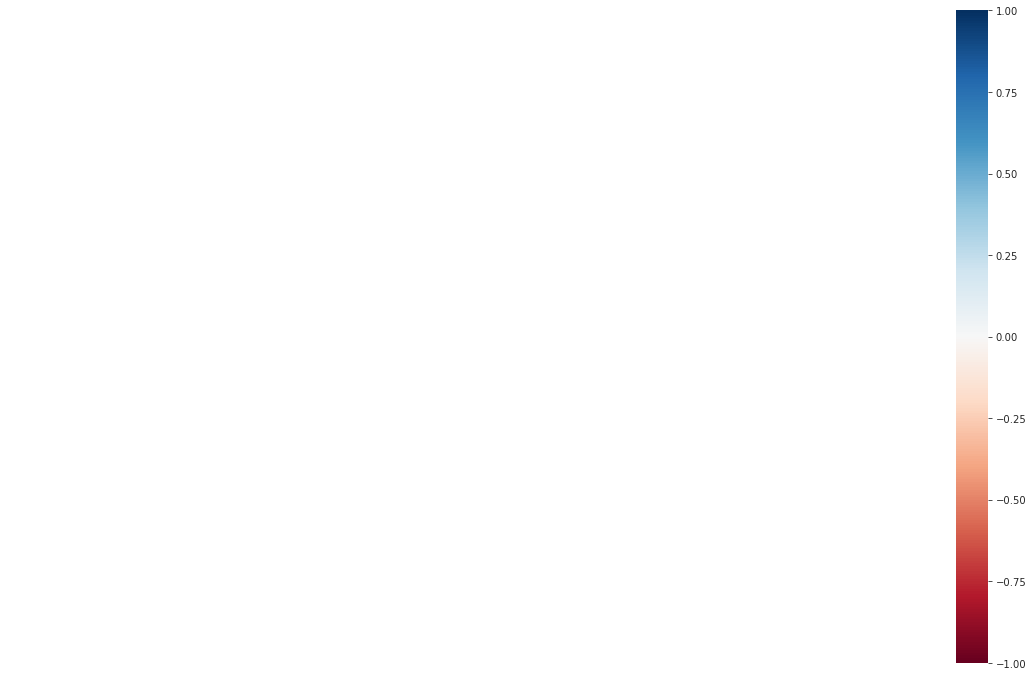

In [149]:
missingness_checks(df)